In [1]:
import pandas as pd

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


import numpy as np

import sqlite3

import xgboost
from xgboost import XGBRegressor

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_predict, KFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from scipy.special import inv_boxcox
from scipy.stats import randint
from sklearn.model_selection import train_test_split, KFold, cross_val_score

import math

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.linear_model import Lasso, Ridge
import statsmodels.api as sm

from scipy import stats
from scipy.stats import t
from scipy.stats import poisson

import seaborn as sns
import matplotlib.pyplot as plt

import pickle
import joblib

import sys
sys.path.insert(0, '../../etl/')
from columns import *

In [2]:
variable = 'PassYards'
target_variable = 'Target' + variable

### DB connect

In [3]:
conn = sqlite3.connect('../../data/nfl.db')

In [4]:
sql_path = '../../sql/PassYards/passyards_training.sql'
with open(sql_path, 'r') as sql_file:
    query = sql_file.read()

raw_data = pd.read_sql_query(query, conn)
print(len(raw_data))

3795


### Filter data for modeling

In [5]:
filtered_data = raw_data.copy()

# In theory, predictions could be negative, 
# but that just over complicates things in practice
#filtered_data = filtered_data[filtered_data[target_variable] > 0]

### Split data into train/test/validation

In [6]:
def convert_odds(american_odds):
    # Convert American Odds to Decimal Odds
    if american_odds > 0:
        decimal_odds = 1 + (american_odds / 100)
    else:
        decimal_odds = 1 - (100 / american_odds)
    return decimal_odds

In [7]:
# Prepare features
lag_features = [i for i in filtered_data.columns if ('Lag' in i)]

# Convert Moneyline to Decimal odds
filtered_data['Moneyline'] = filtered_data['Moneyline'].apply(lambda x: convert_odds(x)) 

features = [i.replace('Lag','') for i in lag_features] + ['PointTotal','Moneyline','HomeFlag']
all_features = features + [target_variable]

In [8]:
train_test_data = filtered_data.copy()

# Replace Lag name in columns
train_test_data.columns = [i.replace('Lag','') for i in train_test_data.columns]

# Handle NAs and inf
#train_test_model_data = train_test_data[all_features].dropna(subset=all_features, how='any').replace([np.inf, -np.inf], np.nan).dropna()

# Split into X and y
X = train_test_data[features]
y = train_test_data[target_variable]

# Split train_test_data into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.reset_index(inplace=True, drop=True)
X_test.reset_index(inplace=True, drop=True)

### Use random search to narrow down hyperparameter grid

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


C:\Users\Sean\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Model training and evaluation runtime: 1416.16 seconds
Best Parameters: {'colsample_bytree': 0.9913676055976528, 'gamma': 0.47202966984330663, 'learning_rate': 0.02577072454740236, 'max_depth': 3, 'min_child_weight': 7, 'n_estimators': 450, 'reg_alpha': 0.18057534512733353, 'reg_lambda': 5.680452305526295, 'subsample': 0.9577441487940209}
Best Score (R-squared): 0.34416220500789646
Test R-squared: 0.342837574328025
Test RMSE: 83.3815
Test MAE: 65.8889


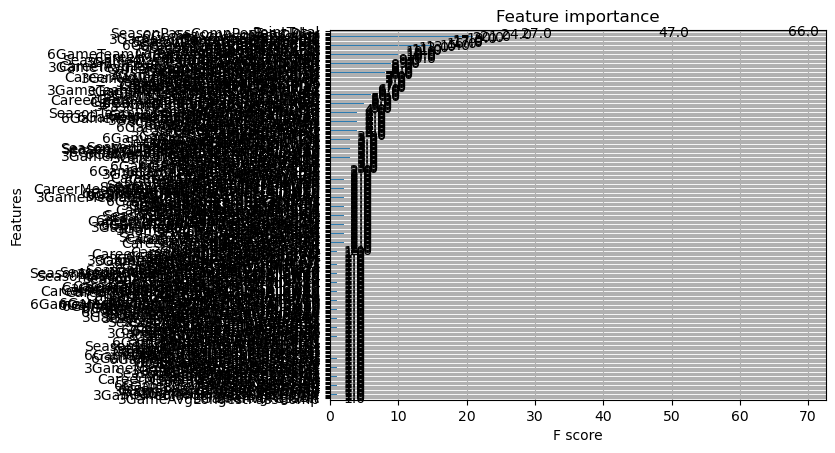

,TargetPassYards,pred_TargetPassYards,residuals
298,275.0,214.799774,60.200226
3078,156.0,244.839218,-88.839218
1361,258.0,206.608566,51.391434
2711,110.0,255.746613,-145.746613
2416,201.0,208.492126,-7.492126


In [9]:
from xgboost import XGBRegressor, plot_importance
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import uniform, randint
import numpy as np
import pandas as pd
import time  # Import time module for runtime measurement
import matplotlib.pyplot as plt

# Define parameter grid for RandomizedSearchCV with improved distributions
param_dist = {
    'n_estimators': randint(50, 500),
    'learning_rate': uniform(0.01, 0.4),  
    'max_depth': randint(2, 10),
    'min_child_weight': randint(1, 10),
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.3, 0.7),
    'gamma': uniform(0, 0.5),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0.001, 10)
}

# Create XGBoost regressor with GPU support (if available)
xgb = XGBRegressor(random_state=42, use_label_encoder=False)

# Set up cross-validation strategy
kfolds = KFold(n_splits=5, shuffle=True, random_state=42)

# Create RandomizedSearchCV with efficient parameter settings
xgb_random = RandomizedSearchCV(
    estimator=xgb, 
    param_distributions=param_dist, 
    n_iter=500, 
    cv=kfolds, 
    verbose=2, 
    random_state=42, 
    n_jobs=-1
)

# Start timer
start_time = time.time()

# Fit the model on the training data
xgb_random.fit(X_train, y_train, early_stopping_rounds=10, eval_set=[(X_test, y_test)], verbose=False)

# End timer
end_time = time.time()

# Calculate and print runtime
runtime = end_time - start_time
print(f"Model training and evaluation runtime: {runtime:.2f} seconds")

# Display best parameters and scores
print("Best Parameters:", xgb_random.best_params_)
print("Best Score (R-squared):", xgb_random.best_score_)

# Evaluate on the test set
best_xgb = xgb_random.best_estimator_

y_pred_test = best_xgb.predict(X_test)
test_r2_score = best_xgb.score(X_test, y_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
test_mae = mean_absolute_error(y_test, y_pred_test)

print("Test R-squared:", test_r2_score)
print(f'Test RMSE: {test_rmse:.4f}')
print(f'Test MAE: {test_mae:.4f}')

# Plot feature importance
plot_importance(best_xgb)
plt.show()

# Create and display output DataFrame
output_df = pd.DataFrame({target_variable: y_test, 'pred_' + target_variable: y_pred_test})
output_df['residuals'] = output_df[target_variable] - output_df['pred_' + target_variable]
output_df.head()


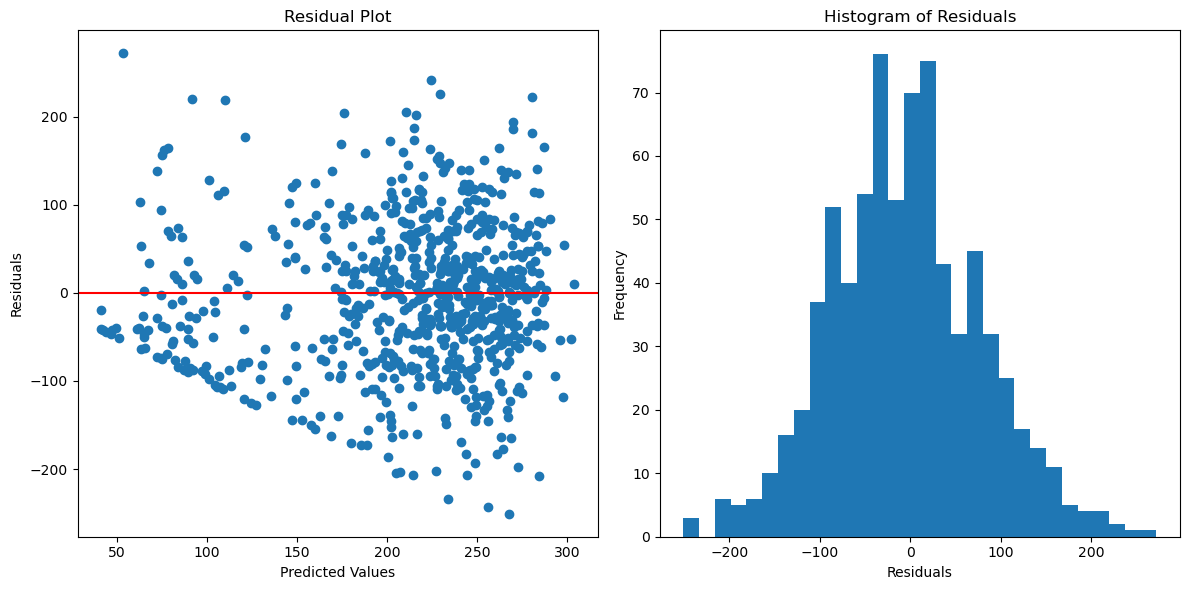

In [10]:
# Calculate residuals
residuals = y_test - y_pred_test

# Create error plots
plt.figure(figsize=(12, 6))

# Residual Plot
plt.subplot(1, 2, 1)
plt.scatter(y_pred_test, residuals)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")

# Histogram of Residuals
plt.subplot(1, 2, 2)
plt.hist(residuals, bins=30)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals")

plt.tight_layout()
plt.show()

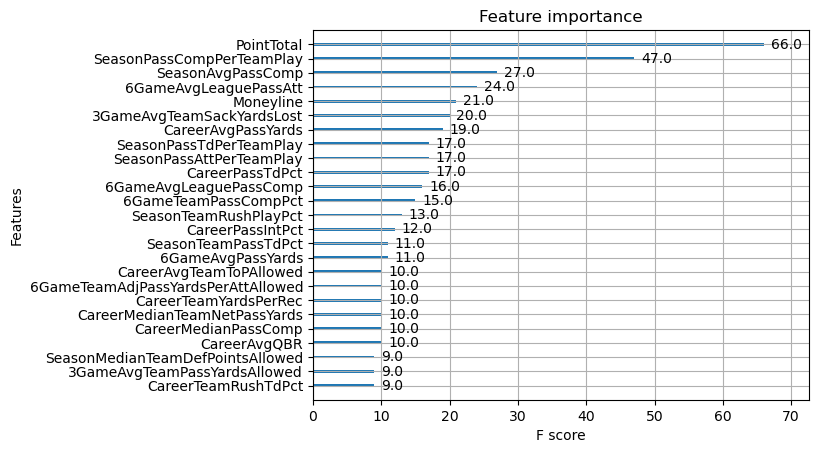

<Figure size 1400x800 with 0 Axes>

In [11]:

# Plot feature importance
xgboost.plot_importance(best_xgb, max_num_features=25)
plt.figure(figsize=(14, 8))
plt.show()

In [12]:
train_test_data['xPassYards'] = best_xgb.predict(train_test_data[features])
train_test_data['Residual'] = train_test_data['TargetPassYards'] - train_test_data['xPassYards']
train_test_data['AbsResidual'] = [np.abs(i) for i in train_test_data['Residual']]

train_test_data.sort_values('AbsResidual', ascending=False)[['GameDate','Player','TargetPassYards','xPassYards','AbsResidual']].head(20)

,GameDate,Player,TargetPassYards,xPassYards,AbsResidual
705,2021-10-31,Cooper Rush,325.0,53.198410,271.801590
1713,2021-12-26,Joe Burrow,525.0,256.162384,268.837616
586,2020-01-05,Carson Wentz,3.0,256.871185,253.871185
2586,2019-10-27,Matt Schaub,460.0,206.243286,253.756714
2626,2020-12-26,Matthew Stafford,17.0,267.614380,250.614380
3151,2021-09-12,Ryan Fitzpatrick,13.0,256.146790,243.146790
3682,2023-09-10,Tua Tagovailoa,466.0,224.242798,241.757202
1510,2019-09-29,Jared Goff,517.0,276.787445,240.212555
3670,2022-09-18,Tua Tagovailoa,469.0,230.632584,238.367416
706,2021-11-14,Cooper Rush,17.0,253.501785,236.501785


### 

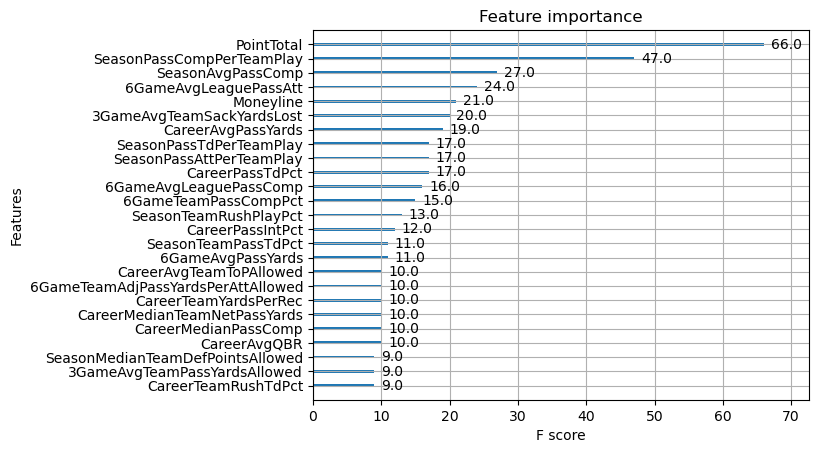

<Figure size 1400x800 with 0 Axes>

In [13]:
# Plot feature importance
xgboost.plot_importance(best_xgb, max_num_features=25)
plt.figure(figsize=(14, 8))
plt.show()

### Persist the best model in the models dir

In [14]:
model_dir = 'C:/Users/Sean/Documents/python/nfl-models/models/PassYards/'

model_file_path = model_dir + 'xgb_x{}_prod.pkl'.format(variable.lower())
joblib.dump(best_xgb, model_file_path)

['C:/Users/Sean/Documents/python/nfl-models/models/PassYards/xgb_xpassyards_prod.pkl']

In [15]:
# Save the model features as a file in models dir to make prod use easier
features_file_path = model_dir + '/features/xgb_x{}_prod.features'.format(variable.lower())

# Open the .txt file in write mode and write the data
with open(features_file_path, 'w') as file:
    for item in features:
        file.write(f"{item}\n")